## Two Application Examples

In this notebook we present two examples of the use of the distance information from the association of LSBG overdensity peaks with galaxy clusters of known distances.

There are two applications:

- Size-Luminosity relationship
- Radial profiles around the most prominent peaks

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import skymap as smap
from skymap import DESSkymap
import healpy as hp
from astropy import units as u
from scipy.special import gamma
from scipy.special import gammainc # Note that the incomplete gamma function 
from scipy.optimize import root_scalar
from astropy.coordinates import SkyCoord
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.4*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

//anaconda/envs/python2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from ._trlib import TRLIBQuadraticSubproblem
//anaconda/envs/python2/lib/python2.7/site-packages/scipy/optimize/_numdiff.py:10: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from ._group_columns import group_dense, group_sparse
//anaconda/envs/python2/lib/python2.7/site-packages/astropy/table/np_utils.py:19: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from . import _np_utils
//anaconda/envs/python2/lib/python2.7/site-packages/astropy/io/ascii/fastbasic.py:9: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from . import 

#### Import the sample

In [2]:
LSBG_df = pd.read_csv('LSBG_catalog.csv')

# RA and DEC
RA = LSBG_df['ra_gfm'].values
DEC = LSBG_df['dec_gfm'].values

# Extinction-corrected magnitudes
mag_g = LSBG_df['mag_gfm_g_corr'].values
mag_r = LSBG_df['mag_gfm_r_corr'].values
mag_i = LSBG_df['mag_gfm_i_corr'].values

#Effective radii 
R_eff_g = LSBG_df['R_eff_g'].values
R_eff_r = LSBG_df['R_eff_r'].values
R_eff_i = LSBG_df['R_eff_i'].values

# Sersic index
n_ser = LSBG_df['n'].values

#Ellipticity
Ell = LSBG_df['ell_gfm'].values

#Calculate axis ratio = b/a
AR = 1.0 - Ell

Calculate (correctly) the mean and central surface brightness. In subsequent versions of this, I can simply import them.

In [3]:
# Mean surface brightnesses

# mean surface brightness in g-band
mu_mean_g = mag_g + 2.5*np.log10(2.0*np.pi*AR*(R_eff_g**2.0))
# mean surface brightness in r-band
mu_mean_r = mag_r + 2.5*np.log10(2.0*np.pi*AR*(R_eff_r**2.0))
# mean surface brightness in i-band
mu_mean_i = mag_i + 2.5*np.log10(2.0*np.pi*AR*(R_eff_i**2.0))
# ===================================================================
# ===================================================================
# First part, calculation of b for a given n. Write a function that does that.
def funct(x, *args):
    """
    The function to be minimized
    """
    n = args[0]
    fun = 2.0*gammainc(2.0*n,x) - 1.0
    return fun
    
def b_return(n):
    """
    This function returns the parameter b for a given
    Sersic index n, solving the equations described above
    """
    
    b_ret = root_scalar(funct, args=(n), method='bisect', bracket=[0.01, 40])
    return b_ret.root
    
b_n = np.zeros(len(n_ser))


for i in range(len(b_n)):
    b_n[i] = b_return(n_ser[i]) 


# Now calculate the function f(n)
f_n = (n_ser*np.exp(b_n)/(b_n**(2.0*n_ser)))*gamma(2.0*n_ser)

# Calculate central surface brightness for the three bands
# g-band first
mu_cent_g = mu_mean_g + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# r-band 
mu_cent_r = mu_mean_r + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# i-band
mu_cent_i = mu_mean_i + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)

Let's import the coordinates and distances of the peaks

In [4]:
# Right Ascension of the peaks
peaks_RA = [21.4200,55.04750,18.475833,9.888208,17.501667,54.616250,21.374583,16.929944,45.977000]

# Declination of the peaks
peaks_DEC = [-1.407222,-18.5875,-31.751944,3.138528,-45.922778,-35.448333,1.762778,-46.916526,-11.991806]

# Distance of the peaks in Mpc
peaks_dists = [75.07,23.41,84.80,62.61,106.61,18.97,73.32,102.03,57.03]

In [5]:
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [6]:
rad_to_deg = 180.0/np.pi

rad_i_1 = np.zeros(46)
mag_i_1 = np.zeros(46)
rad_1 = np.zeros(46)
mag_1 = np.zeros(46)
dist_1 = np.zeros(46)
mu_cent_1 = np.zeros(46)
# ==========================
# ==========================
rad_i_2 = np.zeros(103)
mag_i_2 = np.zeros(103)
rad_2 = np.zeros(103)
mag_2 = np.zeros(103)
dist_2 = np.zeros(103)
mu_cent_2 = np.zeros(103)
# ==========================
# ==========================
rad_i_3 = np.zeros(27)
mag_i_3 = np.zeros(27)
rad_3 = np.zeros(27)
mag_3 = np.zeros(27)
dist_3 = np.zeros(27)
mu_cent_3 = np.zeros(27)
# ==========================
# ==========================
rad_i_4 = np.zeros(36)
mag_i_4 = np.zeros(36)
rad_4 = np.zeros(36)
mag_4 = np.zeros(36)
dist_4 = np.zeros(36)
mu_cent_4 = np.zeros(36)
# ==========================
# ==========================
rad_i_5 = np.zeros(19)
mag_i_5 = np.zeros(19)
rad_5 = np.zeros(19)
mag_5 = np.zeros(19)
dist_5 = np.zeros(19)
mu_cent_5 = np.zeros(19)
# ==========================
# ==========================
rad_i_6 = np.zeros(168)
mag_i_6 = np.zeros(168)
rad_6 = np.zeros(168)
mag_6 = np.zeros(168)
dist_6 = np.zeros(168)
mu_cent_6 = np.zeros(168)
# ==========================
# ==========================
rad_i_7 = np.zeros(24)
mag_i_7 = np.zeros(24)
rad_7 = np.zeros(24)
mag_7 = np.zeros(24)
dist_7 = np.zeros(24)
mu_cent_7 = np.zeros(24)
# ==========================
# ==========================
rad_i_8 = np.zeros(15)
mag_i_8 = np.zeros(15)
rad_8 = np.zeros(15)
mag_8 = np.zeros(15)
dist_8 = np.zeros(15)
mu_cent_8 = np.zeros(15)
# ==========================
# ==========================
rad_i_9 = np.zeros(25)
mag_i_9 = np.zeros(25)
rad_9 = np.zeros(25)
mag_9 = np.zeros(25)
dist_9 = np.zeros(25)
mu_cent_9 = np.zeros(25)

for i in range(9): # In the range of the peaks
    
    ra_pk = peaks_RA[i] # RA of the i-th peak
    dec_pk = peaks_DEC[i] # DEC of the i-th peak
    dist_pk = peaks_dists[i] # Distance of the i-th peak in Mpc
    
    
    # Create a box to select LSB galaxies
    ra_up = ra_pk+4.0
    ra_low = ra_pk-4.0
    dec_up = dec_pk+4.0
    dec_low = dec_pk-4.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    # Keep the LSB galaxies inside the box
    ra_lsb_pk = RA[box_LSB] # ra
    dec_lsb_pk = DEC[box_LSB] # dec
    R_eff_g_pk = R_eff_g[box_LSB] # Effective radius
    R_eff_i_pk = R_eff_i[box_LSB] # i-band Effective radius
    mag_g_pk = mag_g[box_LSB] # magnitude in the g band
    mag_i_pk = mag_i[box_LSB] # magnitude in the i band
    mu_cent_pk = mu_cent_g[box_LSB]
    # =====================================================================
    # =====================================================================
    
    # Calculate now the angular extend of 0.5Mpc at the distance of the i-th peak
    ang_05mpc = rad_to_deg*(0.5/dist_pk)
    
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    
    
    # Keep Effective radii and magnitudes with a separation less than 0.5 Mpc
    R_eff_g_05mpc = R_eff_g_pk[sep_lsb_pk<ang_05mpc]
    R_eff_i_05mpc = R_eff_i_pk[sep_lsb_pk<ang_05mpc]
    mag_g_05mpc = mag_g_pk[sep_lsb_pk<ang_05mpc]
    mag_i_05mpc = mag_i_pk[sep_lsb_pk<ang_05mpc]
    dist_05mpc = sep_lsb_pk[sep_lsb_pk<ang_05mpc] 
    mu_cent_05mpc = mu_cent_pk[sep_lsb_pk<ang_05mpc]
    
    # Now estimate the physical radius (in pc) and the absolute magnitude 
    # of the LSB galaxies around the peak
    
    deg_to_rad = 0.0174533
    radius_g = R_eff_g_05mpc*dist_pk*(4.848)
    radius_i = R_eff_i_05mpc*dist_pk*(4.848)
    Abs_mag_g = mag_g_05mpc +5.0 - 5.0*np.log10(dist_pk*1.0e6)
    Abs_mag_i = mag_i_05mpc +5.0 - 5.0*np.log10(dist_pk*1.0e6)
    phys_dist = dist_05mpc*dist_pk*(1.0e6)*deg_to_rad
    
    if (i==0):
        rad_1[:] = radius_g
        mag_1[:] = Abs_mag_g
        rad_i_1[:] = radius_i
        mag_i_1[:] = Abs_mag_i
        dist_1[:] = phys_dist
        mu_cent_1[:] = mu_cent_05mpc
    elif (i==1):
        rad_2[:] = radius_g
        mag_2[:] = Abs_mag_g
        rad_i_2[:] = radius_i
        mag_i_2[:] = Abs_mag_i
        dist_2[:] = phys_dist
        mu_cent_2[:] = mu_cent_05mpc
    elif (i==2):
        rad_3[:] = radius_g
        mag_3[:] = Abs_mag_g
        rad_i_3[:] = radius_i
        mag_i_3[:] = Abs_mag_i
        dist_3[:] = phys_dist
        mu_cent_3[:] = mu_cent_05mpc
    elif (i==3):
        rad_4[:] = radius_g
        mag_4[:] = Abs_mag_g
        rad_i_4[:] = radius_i
        mag_i_4[:] = Abs_mag_i
        dist_4[:] = phys_dist
        mu_cent_4[:] = mu_cent_05mpc
    elif (i==4):
        rad_5[:] = radius_g
        mag_5[:] = Abs_mag_g
        rad_i_5[:] = radius_i
        mag_i_5[:] = Abs_mag_i
        dist_5[:] = phys_dist
        mu_cent_5[:] = mu_cent_05mpc
    elif (i==5):
        rad_6[:] = radius_g
        mag_6[:] = Abs_mag_g
        rad_i_6[:] = radius_i
        mag_i_6[:] = Abs_mag_i
        dist_6[:] = phys_dist
        mu_cent_6[:] = mu_cent_05mpc
    elif (i==6):
        rad_7[:] = radius_g
        mag_7[:] = Abs_mag_g
        rad_i_7[:] = radius_i
        mag_i_7[:] = Abs_mag_i
        dist_7[:] = phys_dist
        mu_cent_7[:] = mu_cent_05mpc
    elif (i==7):
        rad_8[:] = radius_g
        mag_8[:] = Abs_mag_g
        rad_i_8[:] = radius_i
        mag_i_8[:] = Abs_mag_i
        dist_8[:] = phys_dist
        mu_cent_8[:] = mu_cent_05mpc
    elif (i==8):
        rad_9[:] = radius_g
        mag_9[:] = Abs_mag_g
        rad_i_9[:] = radius_i
        mag_i_9[:] = Abs_mag_i
        dist_9[:] = phys_dist
        mu_cent_9[:] = mu_cent_05mpc
    #print(len(radius_g))

In [7]:
M_mag = np.linspace(-19,8,500)

def R_arr(mu_mn):
    
    alpha = (5.0+mu_mn-M_mag-2.5*np.log10(2.0*np.pi))/5.0
    
    R_a = (4.848*1.0e-6)*(10.0**alpha)
    return R_a

R_arr_24 = R_arr(24.)
R_arr_25 = R_arr(25.)
R_arr_26 = R_arr(26.)
R_arr_27 = R_arr(27.)
R_arr_28 = R_arr(28.)

In [8]:
x_s = np.linspace(-8,-18,200)
y_s = 1839.33*np.ones(200)
y_s = 1500.0*np.ones(200)
y_s_2 = 229.91*np.ones(200)

arc_to_rad = 2.5*4.84814
lower_lims = arc_to_rad*np.asarray(peaks_dists)
x_s = np.linspace(-8,-18,200)


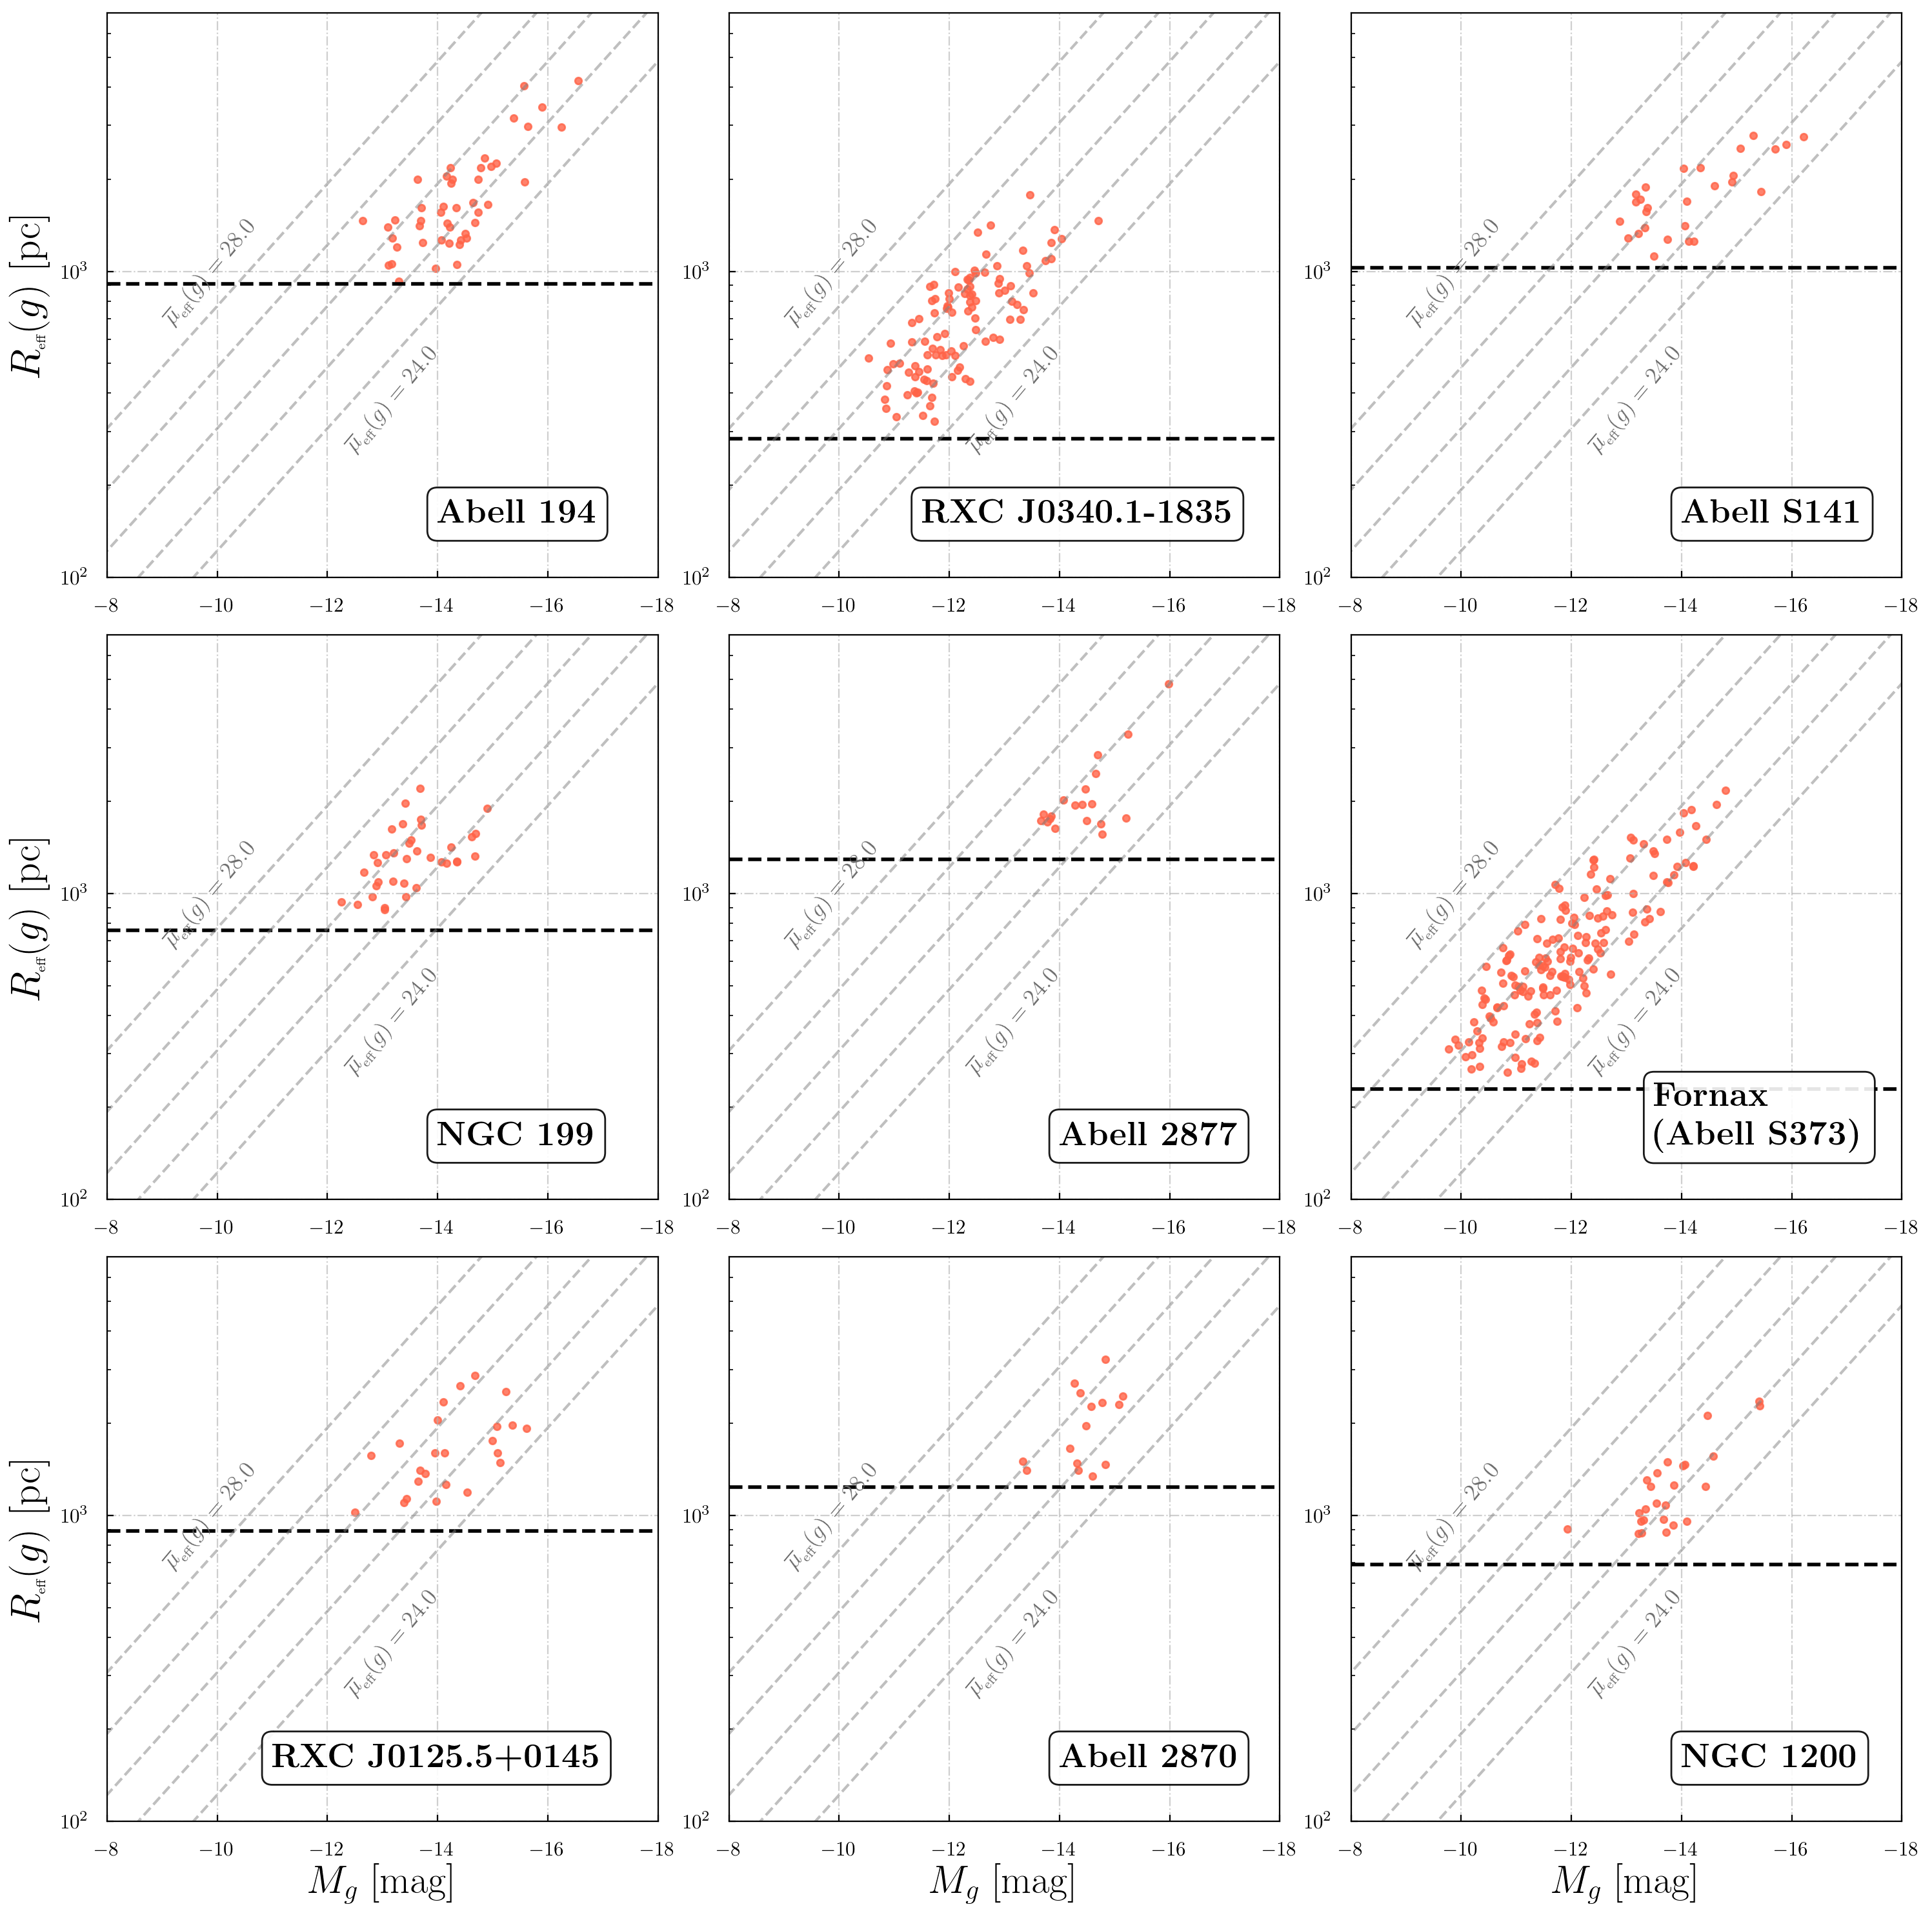

In [9]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

# =====================================================
# =====================================================
plot_pretty()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15.0,15.0))

plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)


# ==========================================================
# ==========================================================
# Plots
axes[0,0].scatter(mag_1,rad_1, s=14.0, color='tomato', marker='o', alpha=0.8)


#axes[0,0].plot(x_s,y,color='k',ls='--')
axes[0,0].grid(ls='-.',alpha=0.6)

# Customize
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(1e2,7e3)
axes[0,0].set_xlim(-8,-18)

axes[0,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)

axes[0,0].plot(x_s,lower_lims[0]*np.ones(200),ls='--',c='k',linewidth=2.0)


axes[0,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,0].text(-14,150,r'\textbf{Abell 194}',bbox=props,fontsize=19)

axes[0,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]',fontsize=23)
# ==========================================================
# ==========================================================
# Plots
axes[0,1].scatter(mag_2,rad_2, s=14.0, color='tomato', marker='o', alpha=0.8)

axes[0,1].plot(x_s,lower_lims[1]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[0,1].plot(x_s,y,color='k',ls='--')
axes[0,1].grid(ls='-.',alpha=0.6)
# Customize
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(1e2,7e3)
axes[0,1].set_xlim(-8,-18)

axes[0,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[0,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,1].text(-11.5,150,r'\textbf{RXC J0340.1-1835}',bbox=props,fontsize=19)



# ==========================================================
# ==========================================================
# Plots 
axes[0,2].scatter(mag_3,rad_3, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[0,2].plot(x_s,lower_lims[2]*np.ones(200),ls='--',c='k',linewidth=2.0)



#axes[0,2].plot(x_s,y,color='k',ls='--')
axes[0,2].grid(ls='-.',alpha=0.6)

# Customize
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(1e2,7e3)
axes[0,2].set_xlim(-8,-18)

axes[0,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[0,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,2].text(-14,150,r'\textbf{Abell S141}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[1,0].scatter(mag_4,rad_4, s=14.0, color='tomato', marker='o', alpha=0.8)

axes[1,0].plot(x_s,lower_lims[3]*np.ones(200),ls='--',c='k',linewidth=2.0)

#axes[1,0].plot(x_s,y,color='k',ls='--')
axes[1,0].grid(ls='-.',alpha=0.6)


# Customize
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(1e2,7e3)
axes[1,0].set_xlim(-8,-18)


axes[1,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,0].text(-14,150,r'\textbf{NGC 199}',bbox=props,fontsize=19)

axes[1,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize=23)
# ==========================================================
# ==========================================================
# Plots
axes[1,1].scatter(mag_5,rad_5, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[1,1].plot(x_s,lower_lims[4]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[1,1].plot(x_s,y,color='k',ls='--')
axes[1,1].grid(ls='-.',alpha=0.6)

# Customize
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(1e2,7e3)
axes[1,1].set_xlim(-8,-18)

axes[1,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,1].text(-14,150,r'\textbf{Abell 2877}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[1,2].scatter(mag_6,rad_6, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[1,2].plot(x_s,lower_lims[5]*np.ones(200),ls='--',c='k',linewidth=2.0)



#axes[1,2].plot(x_s,y,color='k',ls='--')
axes[1,2].grid(ls='-.',alpha=0.6)

# Customize
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(1e2,7e3)
axes[1,2].set_xlim(-8,-18)

axes[1,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,2].text(-13.5,150,r'\textbf{Fornax}''\n' r'\textbf{(Abell S373)}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[2,0].scatter(mag_7,rad_7, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,0].plot(x_s,lower_lims[6]*np.ones(200),ls='--',c='k',linewidth=2.0)

#axes[2,0].plot(x_s,y,color='k',ls='--')
axes[2,0].grid(ls='-.',alpha=0.6)

# Customize
axes[2,0].set_yscale('log')
axes[2,0].set_ylim(1e2,7e3)
axes[2,0].set_xlim(-8,-18)

axes[2,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,0].text(-11,150,r'\textbf{RXC J0125.5+0145}',bbox=props,fontsize=19)


axes[2,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize = 23)
axes[2,0].set_xlabel(r'$M_g$ [mag]', fontsize = 22)
# ==========================================================
# ==========================================================
# Plots
axes[2,1].scatter(mag_8,rad_8, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,1].plot(x_s,lower_lims[7]*np.ones(200),ls='--',c='k',linewidth=2.0)
#axes[2,1].plot(x_s,y,color='k',ls='--')
axes[2,1].grid(ls='-.',alpha=0.6)

# Customize
axes[2,1].set_yscale('log')
axes[2,1].set_ylim(1e2,7e3)
axes[2,1].set_xlim(-8,-18)

axes[2,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,1].text(-14,150,r'\textbf{Abell 2870}',bbox=props,fontsize=19)

axes[2,1].set_xlabel(r'$M_g$ [mag]', fontsize = 22)
# =====================================================================================
# =====================================================================================
# =====================================================================================
# Plots
axes[2,2].scatter(mag_9,rad_9, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,2].plot(x_s,lower_lims[8]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[2,2].plot(x_s,y,color='k',ls='--')
axes[2,2].grid(ls='-.',alpha=0.6)
# Customize
axes[2,2].set_yscale('log')
axes[2,2].set_ylim(1e2,7e3)
axes[2,2].set_xlim(-8,-18)

axes[2,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)

axes[2,2].text(-14,150,r'\textbf{NGC 1200}',bbox=props,fontsize=19)





axes[2,2].set_xlabel(r'$M_g$ [mag]', fontsize = 22)

plt.tight_layout()
#plt.savefig('Size_lum.pdf')
plt.show()

### Size-Luminosity relation and comparison with NGFS in the $i-$band

Let's first get the $i$ magnitude and effective radius of the NGFS sample in the i band.

In [10]:
mag_i_outer, reff_i_outer = np.loadtxt("NGFS_props_outer.dat", usecols=(7,10), unpack=3)
mag_i_inner = np.loadtxt("photometric_inner.dat", usecols=(5), unpack=3)
Reff_i_inner = np.loadtxt("structural_inner.dat", usecols=(4), unpack=3)*1000.

In [11]:
arcsec_to_rad = 4.84814e-6
dist_Forn = 18.97e6

abs_mag_i_outer = mag_i_outer  - 5.0*np.log10(dist_Forn/10.0)
abs_mag_i_inner = mag_i_inner  - 5.0*np.log10(dist_Forn/10.0)
Reff_i_outer = reff_i_outer*arcsec_to_rad*dist_Forn

R_eff_i_NGFS = np.concatenate([Reff_i_inner,Reff_i_outer])
abs_mag_i_NGFS = np.concatenate([abs_mag_i_inner ,abs_mag_i_outer])
#print(Reff_i_outer)


Mag_g_lsb = np.concatenate([mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9])
Mag_i_lsb = np.concatenate([mag_i_1,mag_i_2,mag_i_3,mag_i_4,mag_i_5,mag_i_6,mag_i_7,mag_i_8,mag_i_9])
R_eff_g_lsb = np.concatenate([rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_9])
R_eff_i_lsb = np.concatenate([rad_i_1,rad_i_2,rad_i_3,rad_i_4,rad_i_5,rad_i_6,rad_i_7,rad_i_8,rad_i_9])
mu_cent_lsb = np.concatenate([mu_cent_1,mu_cent_2,mu_cent_3,mu_cent_4,mu_cent_5,mu_cent_6,mu_cent_7,mu_cent_8,mu_cent_9])

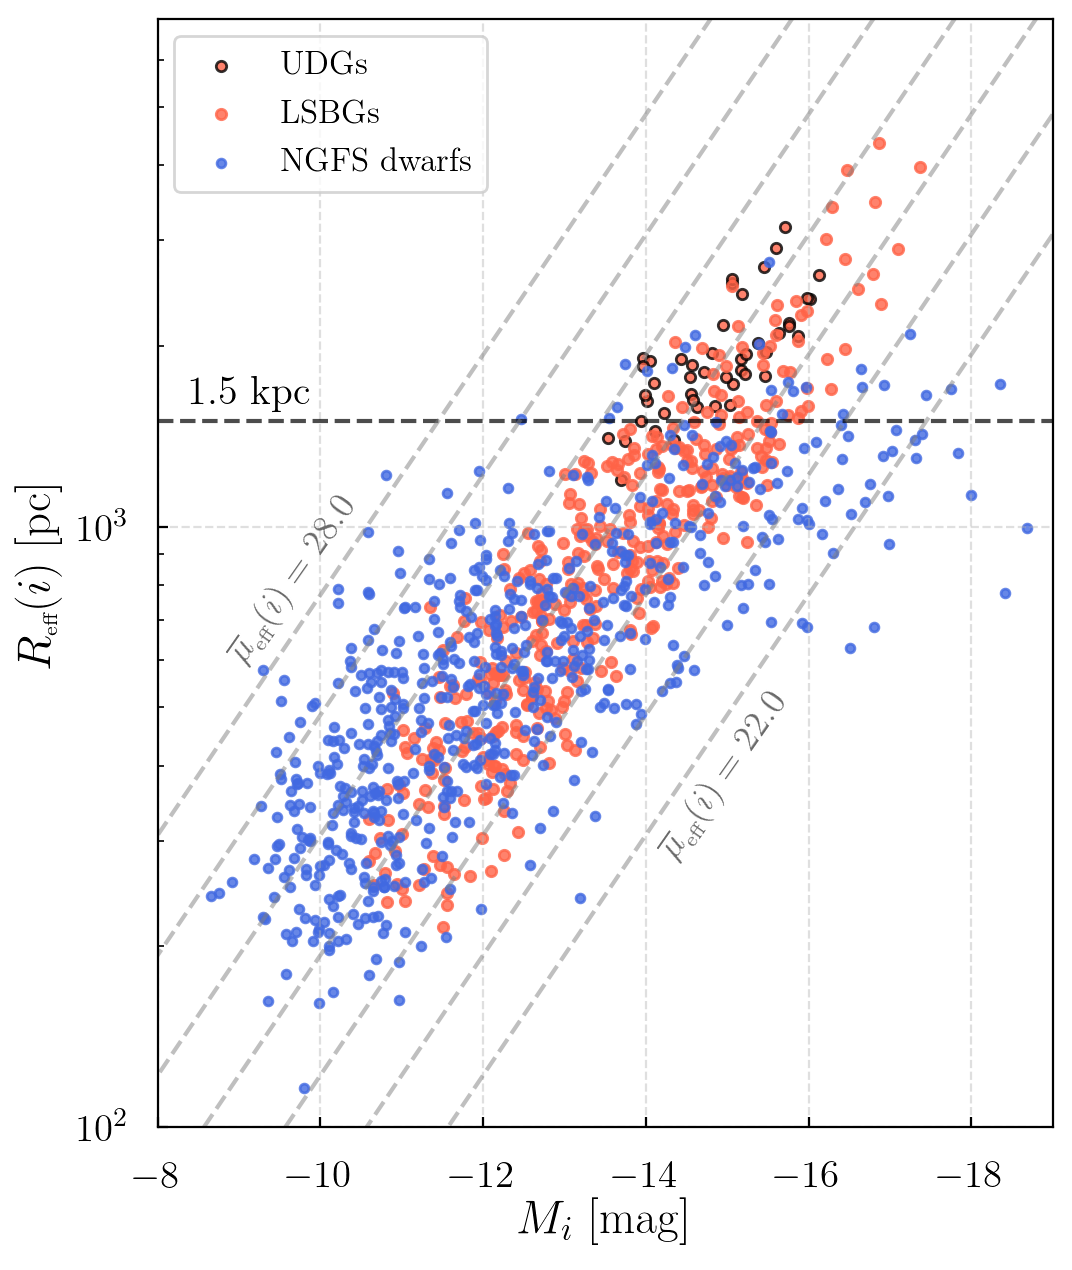

In [14]:
x_s = np.linspace(-8,-19,200)
y_s = 1839.33*np.ones(200)
y_s = 1500.0*np.ones(200)
y_s_2 = 229.91*np.ones(200)
R_arr_23 = R_arr(23.)
R_arr_22 = R_arr(22.)

plt.figure(figsize = (5.5,6.5))

plt.scatter(Mag_i_lsb[(R_eff_g_lsb>1500)&(mu_cent_lsb>24.0)],
            R_eff_i_lsb[(R_eff_g_lsb>1500)&(mu_cent_lsb>24.0)],
            s=14.0, color='tomato', marker='o',edgecolor='k', alpha=0.8,
           label='UDGs')


#plt.scatter(abs_mag_i,R_eff_i,s=10,color='royalblue', marker='o',
#            alpha=0.8, label='NGFS dwarfs')

plt.scatter(Mag_i_lsb[(R_eff_g_lsb<1500)|(mu_cent_lsb<24.0)],
            R_eff_i_lsb[(R_eff_g_lsb<1500)|(mu_cent_lsb<24.0)],
            s=14.0, color='tomato', marker='o', alpha=0.8,
            label='LSBGs')



plt.scatter(abs_mag_i_NGFS,R_eff_i_NGFS,s=10,color='royalblue', marker='o',
            alpha=0.8, label='NGFS dwarfs')

plt.plot(x_s,y_s, ls='--', color='k',alpha=0.7)
#plt.plot(x_s,y_s_2, ls='--', color='k',alpha=0.7)
plt.plot(M_mag, R_arr_22, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_23, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


plt.text(-8.85,1.02e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(i)=28.0$',
         color='dimgray',fontsize=13, rotation=55)
plt.text(-14.15,480, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(i)=22.0$',
         color='dimgray',fontsize=13, rotation=55)
plt.text(-8.4,1.6e3, '1.5 kpc', fontsize = 14.5)

plt.yscale('log')
plt.ylim(1e2,7e3)
plt.xlim(-8,-19)
plt.grid(ls='--',alpha=0.4)
plt.tick_params(axis='both', labelsize=14)

plt.xlabel('$M_i$ [mag]', fontsize=17)
plt.ylabel('$R_{\mbox{\scriptsize{eff}}}(i)$ [pc]', fontsize=17)

plt.legend(frameon=True, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('Size_Lumin_OC.png')
plt.show()

In [13]:
print(len(Mag_i_lsb[(R_eff_g_lsb>1500)&(mu_cent_lsb>24.0)]))

46
